In [3]:
import numpy as np
import pandas as pd
import napari
from skimage.segmentation import relabel_sequential
from tifffile import imread
from stardist.matching import matching, matching_dataset, group_matching_labels
from tqdm import tqdm
from skimage.segmentation import relabel_sequential
import statistics

import sys
import os
from pathlib import Path

cwd = os.getcwd()
# print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[2])
# print(f"Module dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.tools.utils import load_yaml, get_tensorboard_logs
from src.data.preprocess_utils import load_files, resample_crop_downsample
from src.evaluation.evaluate_models import get_boundary_based_metrics_per_object

import seaborn as sns

sns.set(font_scale=1.2)
sns.set_palette("Set2")

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

## Experiments´ directories

In [2]:
base_cfg_dir = r"C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments"

exp_dir_gasp = []
exp_dir_mc = []
exp_dir_ws2d = []
exp_dir_mute = []

for i in [4, 5, 6, 7, 8, 9]:
    exp_dir_gasp.append(os.path.join(base_cfg_dir, "exp14-1_pred_blur" + str(i)))
    exp_dir_mc.append(os.path.join(base_cfg_dir, "exp14-1_pred_blur" + str(i) + "_mc"))
    exp_dir_ws2d.append(os.path.join(base_cfg_dir, "exp14-1_pred_blur" + str(i) + "_ws2d"))
    exp_dir_mute.append(os.path.join(base_cfg_dir, "exp14-1_pred_blur" + str(i) + "_mute"))


In [5]:
#raw =           load_files(r"C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\plantseg_train_val_test_2022-08-17\test\raw")
#y_true, fnames = load_files(r"C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\plantseg_train_val_test_2022-08-17\test\labels", return_fnames=True)
y_true, fnames = load_files(r"C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\matched_test_set\anisotropic", return_fnames=True)

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\matched_test_set\anisotropic


## Configurations of segmentation

In [5]:
cfg_base_dir = "C:/Users/lazi257c/Projects/organoid-segmentation-ML/src/config/experiments"

## Load predictions

In [6]:
pred_gasp = []
pred_mc = []
pred_ws2d = []
pred_mute = []

In [7]:
for path_gasp, path_mc, path_ws2d,path_mute in zip(exp_dir_gasp, exp_dir_mc, exp_dir_ws2d, exp_dir_mute):
    pred_gasp.append(load_files(os.path.join(path_gasp, "results-defaults", "Segmentation","PostProcessing")))
    pred_mc.append(load_files(os.path.join(path_mc, "results-defaults", "Segmentation","PostProcessing")))
    pred_ws2d.append(load_files(os.path.join(path_ws2d, "results-defaults", "Segmentation","PostProcessing")))
    pred_mute.append(load_files(os.path.join(path_mute, "results-defaults", "Segmentation","PostProcessing")))


Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur4\results-defaults\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur4_mc\results-defaults\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur4_ws2d\results-defaults\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur4_mute\results-defaults\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur5\results-defaults\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur5_mc\results-defaults\Segmentation\PostProce

In [8]:
# changing ws threshold AND beta, now folder renamed results-beta_0,x_ws_thres_0,x
#exp_dir_b_n_ws_thres = []

#for i in [4, 5, 6, 7, 8, 9]:
#    exp_dir_b_n_ws_thres.append(os.path.join(base_cfg_dir, "exp14-1_pred_blur" + str(i) + "_ws2d"))

#pred_b_n_ws_thres = []
#for path, i in zip(exp_dir_ws_thres, [4, 5, 6, 7, 8, 9]):
#    pred_b_n_ws_thres.append(load_files(os.path.join(path, "results-beta_0," + str(i) + "_ws_thres_0," + str(i), "Segmentation","PostProcessing")))

In [9]:
# changing ws threshold, but not beta, which remains 0.7, results folder named results-beta_0,7_ws_thres_0,x
exp_dir_ws_thres = []

for i in [4, 5, 6, 7, 8, 9]:
    exp_dir_ws_thres.append(os.path.join(base_cfg_dir, "exp14-1_pred_blur" + str(i)))

pred_ws_thres = []
for path, i in zip(exp_dir_ws_thres, [4, 5, 6, 7, 8, 9]):
    pred_ws_thres.append(load_files(os.path.join(path, "results-beta_0,7_ws_thres_0," + str(i), "Segmentation", "PostProcessing")))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur4\results-beta_0,7_ws_thres_0,4\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur5\results-beta_0,7_ws_thres_0,5\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur6\results-beta_0,7_ws_thres_0,6\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur7\results-beta_0,7_ws_thres_0,7\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur8\results-beta_0,7_ws_thres_0,8\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_p

In [10]:
exp_dir_size = []

for i in [4, 5, 6, 7, 8, 9]:
    exp_dir_size.append(os.path.join(base_cfg_dir, "exp14-1_pred_blur" + str(i) + "_wtsize"))

pred_size = []
for path in exp_dir_size:
    pred_size.append(load_files(os.path.join(path, "results", "Segmentation","PostProcessing")))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur4_wtsize\results\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur5_wtsize\results\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur6_wtsize\results\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur7_wtsize\results\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur8_wtsize\results\Segmentation\PostProcessing
Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur9_wtsize\results\Segmentation\PostProcessing


In [11]:
#exp_dir_wt = []

#for i in [4, 5, 6, 7, 8, 9]:
#    if i ==4:
#        exp_dir_wt.append(os.path.join(base_cfg_dir, "exp14-1_pred_blur" + str(i)))

#pred_wt = []
#for path in exp_dir_wt:
#    pred_wt.append(load_files(os.path.join(path, "results", "Segmentation","PostProcessing")))

In [12]:
exp_dir = os.path.join(base_cfg_dir, "exp14-1_pred_blur_trial")
pred = load_files(os.path.join(exp_dir, "results", "Segmentation","PostProcessing"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur_trial\results\Segmentation\PostProcessing


In [13]:
exp_dir_defaults = os.path.join(base_cfg_dir, "exp13-defaults")
pred_defaults = load_files(os.path.join(exp_dir_defaults, "results", "Segmentation","PostProcessing"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp13-defaults\results\Segmentation\PostProcessing


## Metrics

In [14]:
metrics_gasp = []
metrics_mc = []
metrics_ws2d = []
metrics_mute = []

In [15]:
for p in tqdm(pred_mute, total=len(pred_gasp)):  # for each beta value
    metrics_mute.append(matching_dataset(np.array(y_true).astype("int32"), np.array(p).astype("int32"), thresh=0.3, show_progress=False))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:36<00:00,  6.03s/it]


In [16]:
for gasp, mc, ws2d in tqdm(zip(pred_gasp, pred_mc, pred_ws2d), total=len(pred_gasp)):  # for each beta value
    metrics_gasp.append(matching_dataset(np.array(y_true).astype("int32"), np.array(gasp).astype("int32"), thresh=0.3, show_progress=False))
    metrics_mc.append(matching_dataset(np.array(y_true).astype("int32"), np.array(mc).astype("int32"), thresh=0.3, show_progress=False))
    metrics_ws2d.append(matching_dataset(np.array(y_true).astype("int32"), np.array(ws2d).astype("int32"), thresh=0.3, show_progress=False))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:42<00:00, 17.04s/it]


In [17]:
metrics_size = []
for p in tqdm(pred_size):
    metrics_size.append(matching_dataset(np.array(y_true).astype("int32"), np.array(p).astype("int32"), thresh=0.3, show_progress=False))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:36<00:00,  6.17s/it]


In [18]:
metrics_ws_thres = []
for p in tqdm(pred_ws_thres):
    metrics_ws_thres.append(matching_dataset(np.array(y_true).astype("int32"), np.array(p).astype("int32"), thresh=0.3, show_progress=False))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:34<00:00,  5.71s/it]


In [19]:
#metrics_wt = []
#for p in tqdm(pred_wt):
#    metrics_wt.append(matching_dataset(np.array(y_true).astype("int32"), np.array(p).astype("int32"), thresh=0.3, show_progress=False))

In [20]:
metrics_try = matching_dataset(np.array(y_true).astype("int32"), np.array(pred).astype("int32"), thresh=0.3, show_progress=False)

In [21]:
metrics_defaults = matching_dataset(np.array(y_true).astype("int32"), np.array(pred_defaults).astype("int32"), thresh=0.3, show_progress=False)

### Put metrics into Data Frame

In [25]:
beta = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [26]:
metrics_gasp_dict = {}
for b, metric in zip(beta, metrics_gasp):
    metrics_gasp_dict[b] = {}
    for m in ("precision", "recall", "accuracy", "f1", "panoptic_quality"):
        metrics_gasp_dict[b][m] = metric._asdict()[m]

In [27]:
metrics_wsthres_dict = {}
for b, metric in zip(beta, metrics_ws_thres):
    metrics_wsthres_dict[b] = {}
    for m in ("precision", "recall", "accuracy", "f1", "panoptic_quality"):
        metrics_wsthres_dict[b][m] = metric._asdict()[m]

In [28]:
metrics_mc_dict = {}
for b, metric in zip(beta, metrics_mc):
    metrics_mc_dict[b] = {}
    for m in ("precision", "recall", "accuracy", "f1","panoptic_quality"):
        metrics_mc_dict[b][m] = metric._asdict()[m]

In [29]:
metrics_ws2d_dict = {}
for b, metric in zip(beta, metrics_ws2d):
    metrics_ws2d_dict[b] = {}
    for m in ("precision", "recall", "accuracy", "f1", "panoptic_quality"):
        metrics_ws2d_dict[b][m] = metric._asdict()[m]

In [30]:
metrics_mute_dict = {}
for b, metric in zip(beta, metrics_mute):
    metrics_mute_dict[b] = {}
    for m in ("precision", "recall", "accuracy", "f1", "panoptic_quality"):
        metrics_mute_dict[b][m] = metric._asdict()[m]

In [31]:
df = pd.DataFrame.from_dict(metrics_gasp_dict, orient="index").stack().to_frame()
df1 = pd.DataFrame.from_dict(metrics_mc_dict, orient="index").stack().to_frame()
df2 = pd.DataFrame.from_dict(metrics_ws2d_dict, orient="index").stack().to_frame()
df3 = pd.DataFrame.from_dict(metrics_mute_dict, orient="index").stack().to_frame()
df4 = pd.DataFrame.from_dict(metrics_wsthres_dict, orient="index").stack().to_frame()

In [32]:
# to break out the lists into columns
df = pd.DataFrame(df[0].values.tolist(), index=df.index)
df.columns = ["GASP Ws3D"]
df1 = pd.DataFrame(df1[0].values.tolist(), index=df.index)
df1.columns = ["GASP Ws2D"]
df2 = pd.DataFrame(df2[0].values.tolist(), index=df.index)
df2.columns = ["MultiCut"]
df3 = pd.DataFrame(df3[0].values.tolist(), index=df.index)
df3.columns = ["MuteXWS"]
df4 = pd.DataFrame(df4[0].values.tolist(), index=df.index)
df4.columns = ["GASP Ws3D Beta 0.7"]

In [33]:
final_df = pd.concat([df,df4,df2,df1, df3],axis=1)
final_df.columns = ["GASP Ws3D","GASP Ws3D Beta 0.7","GASP Ws2D","MultiCut","MuteXWS"]
final_df

GASP Ws3D  GASP Ws3D Beta 0.7  GASP Ws2D  MultiCut  \
0.4 precision          0.734375            0.440000   0.278922  0.731183   
    recall             0.519337            0.972376   0.486188  0.563536   
    accuracy           0.437209            0.434568   0.215422  0.466819   
    f1                 0.608414            0.605852   0.354481  0.636505   
    panoptic_quality   0.411937            0.451138   0.235882  0.433741   
0.5 precision          0.687003            0.527190   0.204152  0.677083   
    recall             0.715470            0.964088   0.651934  0.718232   
    accuracy           0.539583            0.517037   0.184087  0.534979   
    f1                 0.700947            0.681641   0.310935  0.697051   
    panoptic_quality   0.488814            0.507372   0.208951  0.492847   
0.6 precision          0.620408            0.581395   0.147419  0.619718   
    recall             0.839779            0.966851   0.765193  0.850829   
    accuracy           0.554745            0.570033   0.141039  0.558984   
    f1                 0.713615            0.726141   0.247211  0.717113   
    panoptic_quality   0.517027            0.542749   0.168430  0.522073   
0.7 precision          0.581395            0.589615   0.114685  0.581126   
    recall             0.966851            0.972376   0.906077  0.969613   
    accuracy           0.570033            0.579901   0.113338  0.570732   
    f1                 0.726141            0.734098   0.203600  0.726708   
    panoptic_quality   0.542749            0.546372   0.143474  0.543818   
0.8 precision          0.506383            0.621864   0.079768  0.504950   
    recall             0.986188            0.958564   0.988950  0.986188   
    accuracy           0.502817            0.605585   0.079697  0.501404   
    f1                 0.669166            0.754348   0.147629  0.667914   
    panoptic_quality   0.495051            0.563694   0.099561  0.495300   
0.9 precision          0.416764            0.641651   0.016211  0.414832   
    recall             0.988950            0.944751   0.361878  0.988950   
    accuracy           0.414832            0.618445   0.015760  0.412918   
    f1                 0.586405            0.764246   0.031032  0.584490   
    panoptic_quality   0.430573            0.569732   0.014389  0.429309   

                       MuteXWS  
0.4 precision         0.689922  
    recall            0.491713  
    accuracy          0.402715  
    f1                0.574194  
    panoptic_quality  0.389722  
0.5 precision         0.666667  
    recall            0.685083  
    accuracy          0.510288  
    f1                0.675749  
    panoptic_quality  0.466052  
0.6 precision         0.608081  
    recall            0.831492  
    accuracy          0.541367  
    f1                0.702450  
    panoptic_quality  0.507392  
0.7 precision         0.571664  
    recall            0.958564  
    accuracy          0.557878  
    f1                0.716202  
    panoptic_quality  0.535672  
0.8 precision         0.498596  
    recall            0.980663  
    accuracy          0.493741  
    f1                0.661080  
    panoptic_quality  0.490789  
0.9 precision         0.410550  
    recall            0.988950  
    accuracy          0.408676  
    f1                0.580227  
    panoptic_quality  0.426622

In [36]:
final_df = pd.concat([df,df4,df2,df1, df3],axis=1)
final_df.columns = ["GASP Ws3D","GASP Ws3D Beta 0.7","GASP Ws2D","MultiCut","MuteXWS"]
final_df

GASP Ws3D  GASP Ws3D Beta 0.7  GASP Ws2D  MultiCut  \
0.4 precision          0.734375            0.440000   0.278922  0.731183   
    recall             0.519337            0.972376   0.486188  0.563536   
    accuracy           0.437209            0.434568   0.215422  0.466819   
    f1                 0.608414            0.605852   0.354481  0.636505   
    panoptic_quality   0.411937            0.451138   0.235882  0.433741   
0.5 precision          0.687003            0.527190   0.204152  0.677083   
    recall             0.715470            0.964088   0.651934  0.718232   
    accuracy           0.539583            0.517037   0.184087  0.534979   
    f1                 0.700947            0.681641   0.310935  0.697051   
    panoptic_quality   0.488814            0.507372   0.208951  0.492847   
0.6 precision          0.620408            0.581395   0.147419  0.619718   
    recall             0.839779            0.966851   0.765193  0.850829   
    accuracy           0.554745            0.570033   0.141039  0.558984   
    f1                 0.713615            0.726141   0.247211  0.717113   
    panoptic_quality   0.517027            0.542749   0.168430  0.522073   
0.7 precision          0.581395            0.589615   0.114685  0.581126   
    recall             0.966851            0.972376   0.906077  0.969613   
    accuracy           0.570033            0.579901   0.113338  0.570732   
    f1                 0.726141            0.734098   0.203600  0.726708   
    panoptic_quality   0.542749            0.546372   0.143474  0.543818   
0.8 precision          0.506383            0.621864   0.079768  0.504950   
    recall             0.986188            0.958564   0.988950  0.986188   
    accuracy           0.502817            0.605585   0.079697  0.501404   
    f1                 0.669166            0.754348   0.147629  0.667914   
    panoptic_quality   0.495051            0.563694   0.099561  0.495300   
0.9 precision          0.416764            0.641651   0.016211  0.414832   
    recall             0.988950            0.944751   0.361878  0.988950   
    accuracy           0.414832            0.618445   0.015760  0.412918   
    f1                 0.586405            0.764246   0.031032  0.584490   
    panoptic_quality   0.430573            0.569732   0.014389  0.429309   

                       MuteXWS  
0.4 precision         0.689922  
    recall            0.491713  
    accuracy          0.402715  
    f1                0.574194  
    panoptic_quality  0.389722  
0.5 precision         0.666667  
    recall            0.685083  
    accuracy          0.510288  
    f1                0.675749  
    panoptic_quality  0.466052  
0.6 precision         0.608081  
    recall            0.831492  
    accuracy          0.541367  
    f1                0.702450  
    panoptic_quality  0.507392  
0.7 precision         0.571664  
    recall            0.958564  
    accuracy          0.557878  
    f1                0.716202  
    panoptic_quality  0.535672  
0.8 precision         0.498596  
    recall            0.980663  
    accuracy          0.493741  
    f1                0.661080  
    panoptic_quality  0.490789  
0.9 precision         0.410550  
    recall            0.988950  
    accuracy          0.408676  
    f1                0.580227  
    panoptic_quality  0.426622

In [37]:
print(final_df.to_latex(index=True)) 

\begin{tabular}{llrrrrr}
\toprule
    &                  &  GASP Ws3D &  GASP Ws3D Beta 0.7 &  GASP Ws2D &  MultiCut &   MuteXWS \\
\midrule
0.4 & precision &   0.734375 &            0.440000 &   0.278922 &  0.731183 &  0.689922 \\
    & recall &   0.519337 &            0.972376 &   0.486188 &  0.563536 &  0.491713 \\
    & accuracy &   0.437209 &            0.434568 &   0.215422 &  0.466819 &  0.402715 \\
    & f1 &   0.608414 &            0.605852 &   0.354481 &  0.636505 &  0.574194 \\
    & panoptic\_quality &   0.411937 &            0.451138 &   0.235882 &  0.433741 &  0.389722 \\
0.5 & precision &   0.687003 &            0.527190 &   0.204152 &  0.677083 &  0.666667 \\
    & recall &   0.715470 &            0.964088 &   0.651934 &  0.718232 &  0.685083 \\
    & accuracy &   0.539583 &            0.517037 &   0.184087 &  0.534979 &  0.510288 \\
    & f1 &   0.700947 &            0.681641 &   0.310935 &  0.697051 &  0.675749 \\
    & panoptic\_quality &   0.488814 &            0.50

2355065835.py (1): In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [281]:
final_df.unstack()

GASP Ws3D                                                GASP Ws2D  \
    precision    recall  accuracy        f1 panoptic_quality precision   
0.4  0.722656  0.511050  0.427252  0.598706         0.402462  0.278922   
0.5  0.687003  0.715470  0.539583  0.700947         0.478449  0.202422   
0.6  0.620408  0.839779  0.554745  0.713615         0.505896  0.146887   
0.7  0.581395  0.966851  0.570033  0.726141         0.538790  0.114685   
0.8  0.506383  0.986188  0.502817  0.669166         0.491318  0.079768   
0.9  0.416764  0.988950  0.414832  0.586405         0.427391  0.016335   

                                                    MultiCut            \
       recall  accuracy        f1 panoptic_quality precision    recall   
0.4  0.486188  0.215422  0.354481         0.233191  0.727599  0.560773   
0.5  0.646409  0.182243  0.308300         0.205540  0.677083  0.718232   
0.6  0.762431  0.140458  0.246319         0.168189  0.619718  0.850829   
0.7  0.906077  0.113338  0.203600         0.143699  0.581126  0.969613   
0.8  0.988950  0.079697  0.147629         0.100220  0.504950  0.986188   
0.9  0.364641  0.015883  0.031269         0.014781  0.414832  0.988950   

                                          
     accuracy        f1 panoptic_quality  
0.4  0.463470  0.633385         0.426615  
0.5  0.534979  0.697051         0.483210  
0.6  0.558984  0.717113         0.510890  
0.7  0.570732  0.726708         0.539736  
0.8  0.501404  0.667914         0.491612  
0.9  0.412918  0.584490         0.426143

### Dependance on the chosen BETA value for under/over segmentation

  1. GASP (average): is a generalization of the classical hierarchical clustering. It usually deliver very 
    reliable and accurate segmentation. It is the default in PlantSeg.
  2. MutexWS: Mutex Watershed is a derivative of the standard Watershed where we do not need seeds for the
     segmentation. This algorithm performs very well in certain types of complex morphology (like )
  3. MultiCut: in contrast to the other algorithms is not based on a greedy agglomeration but tries to find the 
    global optimal segmentation. This is in practice very hard and it can infeasible for very large stacks.
  4. DtWatershed: is our implementation of the distance transform Watershed. From the imput we extract a distance map 
    from the boundaries. Based this distance map, seeds are placed at local minima.  Then those seeds are used for 
    computing the Watershed segmentation. To speed up the computation of GASP, MutexWS and MultiCut an over segmentation
     is obtained using Dt Watershed. 


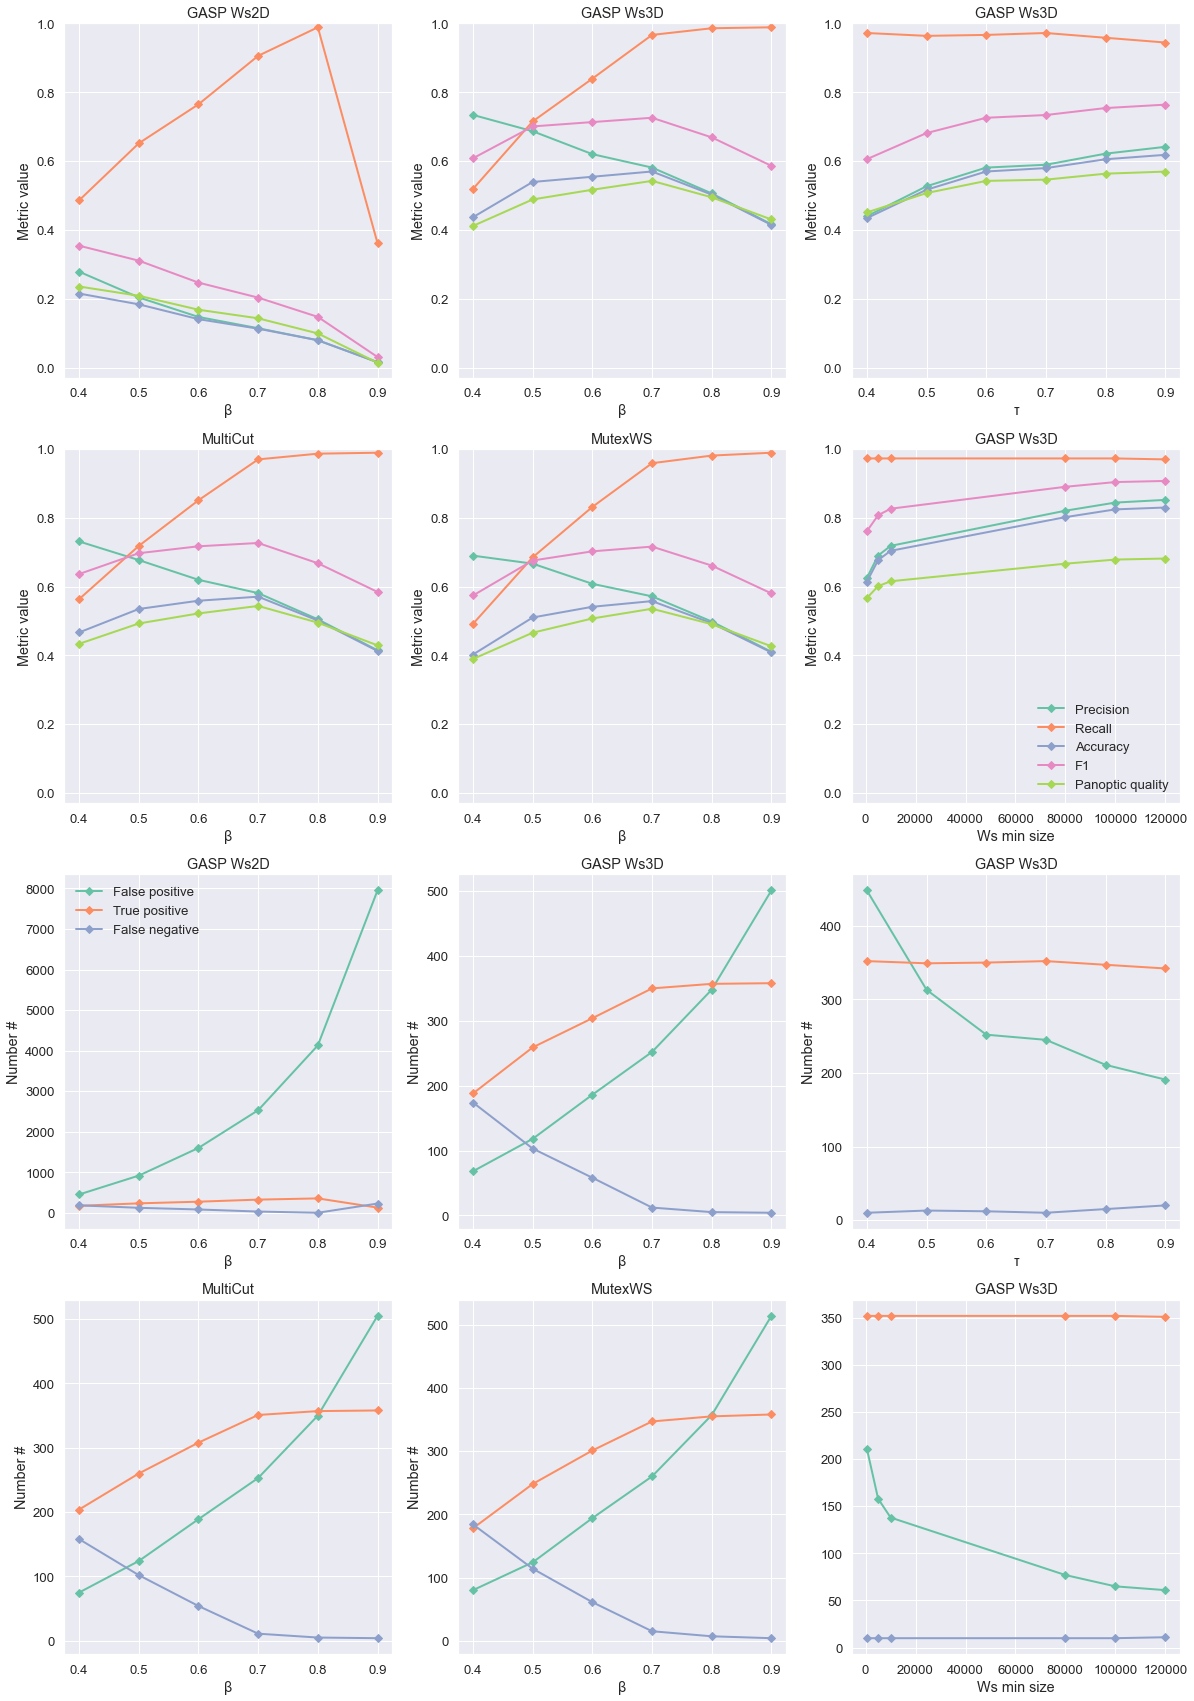

In [22]:

#fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
fig, ((ax1,ax2,ax3), (ax4,ax5, ax6),(ax11,ax21,ax31),(ax41,ax51,ax61))= plt.subplots(4,3, figsize=(20,30))
#for gasp, mc, ws2d in tqdm(zip(metrics_gasp, metrics_mc, metrics_ws2d), total=len(pred_gasp)):
labels = ('Precision', 'Recall', 'Accuracy', 'F1', 'Panoptic quality')
for m, lbl in zip(('precision', 'recall', 'accuracy', 'f1', 'panoptic_quality'), labels):
    ax2.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_gasp], 'D-', linewidth=2, label=lbl)
    ax1.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_ws2d], 'D-', linewidth=2, label=lbl)
    ax4.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_mc], 'D-',   linewidth=2, label=lbl)
    ax5.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_mute[0:6]], 'D-',   linewidth=2, label=lbl)
    ax3.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_ws_thres], 'D-',   linewidth=2, label=lbl)
    ax6.plot([500, 5000, 10000, 80000, 100000, 120000], [s._asdict()[m] for s in metrics_size], 'D-',   linewidth=2, label=lbl)
   # ax2.plot([0.7],  [metrics_size[2]._asdict()[m]], 'D',   linewidth=2, label=lbl)

ax2.set_title(r'GASP Ws3D')
ax3.set_title(r'GASP Ws3D') # β 0.7
ax1.set_title(r'GASP Ws2D')
ax4.set_title(r'MultiCut')
ax5.set_title(r'MutexWS')
ax6.set_title(r'GASP Ws3D')
ax1.set_xlabel(r'β')
ax3.set_xlabel(r'τ')
ax6.set_xlabel(r'τ')
ax2.set_xlabel(r'β')
ax4.set_xlabel(r'β')
ax5.set_xlabel(r'β')
ax6.set_xlabel(r'Ws min size')
ax1.set_ylabel('Metric value')
ax2.set_ylabel('Metric value')
ax3.set_ylabel('Metric value')
ax4.set_ylabel('Metric value')
ax5.set_ylabel('Metric value')
ax6.set_ylabel('Metric value')
ax1.set_ylim([-0.03, 1.0])
ax2.set_ylim([-0.03, 1.0])
ax3.set_ylim([-0.03, 1.0])
ax5.set_ylim([-0.03, 1.0])
ax4.set_ylim([-0.03, 1.0])
ax6.set_ylim([-0.03, 1.0])
#ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax6.legend(frameon=False, loc='lower right')

labels=('False positive', 'True positive', 'False negative')
for m,lbl in zip(('fp', 'tp', 'fn'), labels):
    ax21.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_gasp], 'D-', lw=2, label=lbl)
    ax31.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_ws_thres], 'D-',   linewidth=2, label=lbl)
    ax11.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_ws2d], 'D-', lw=2, label=lbl)
    ax41.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_mc], 'D-', lw=2, label=lbl)
    ax51.plot([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [s._asdict()[m] for s in metrics_mute[0:6]], 'D-',   linewidth=2, label=lbl)
    #ax21.plot([0.7],  [metrics_wt[0]._asdict()[m]], 'D',   linewidth=2, label=lbl)
    ax61.plot([500, 5000, 10000, 80000, 100000, 120000], [s._asdict()[m] for s in metrics_size], 'D-',   linewidth=2, label=lbl)
    #ax11.plot([0.7],  [metrics45000._asdict()[m]], 'D',   linewidth=2, label=lbl)
   
    
ax11.set_xlabel(r'β')
ax31.set_xlabel(r'τ')
ax21.set_xlabel(r'β')
ax41.set_xlabel(r'β')
ax51.set_xlabel(r'β')
ax61.set_xlabel(r'Ws min size')
ax11.set_ylabel('Number #')
ax21.set_ylabel('Number #')
ax31.set_ylabel('Number #')
ax41.set_ylabel('Number #')
ax51.set_ylabel('Number #')
ax21.set_title(r'GASP Ws3D')
ax31.set_title(r'GASP Ws3D') # β 0.7
ax11.set_title(r'GASP Ws2D')
ax41.set_title(r'MultiCut')
ax51.set_title(r'MutexWS')
ax61.set_title(r'GASP Ws3D')
ax11.legend(frameon=False)

#ax1.set_title('A', fontsize=22, color='black', loc='left', pad=20)

plt.savefig(r"C:\Users\lazi257c\Desktop\thesis_figures\plantseg_param_plots.png", bbox_inches='tight')

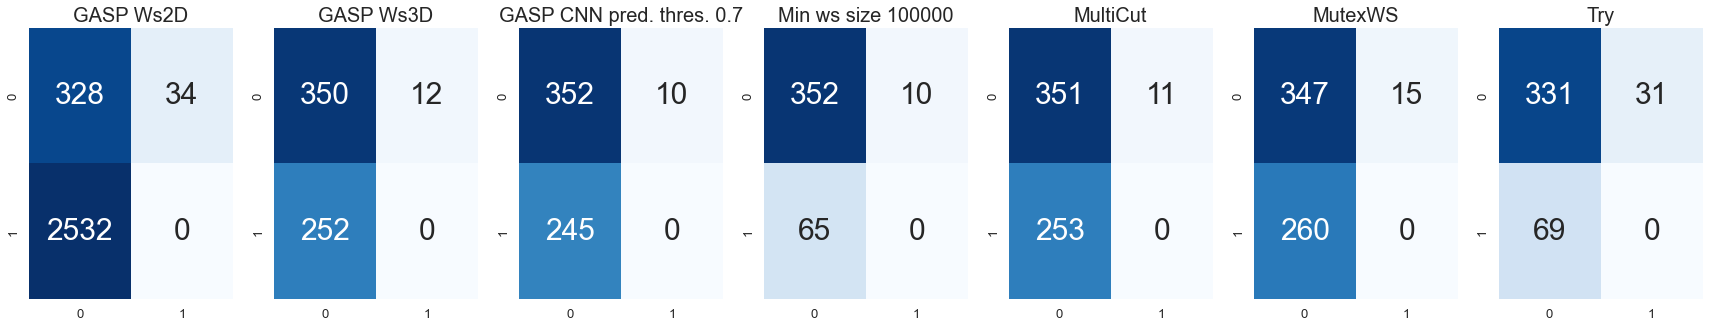

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30,5))
labels = ["GASP Ws2D","GASP Ws3D", "GASP CNN pred. thres. 0.7", "Min ws size 100000","MultiCut", "MutexWS",  "Try"]
metrics = [metrics_ws2d[3], metrics_gasp[3], metrics_ws_thres[3], metrics_size[4],  metrics_mc[3], metrics_mute[3],  metrics_try]
for met, ax,lbl in zip(metrics, axes.flatten(), labels):
    cm_data_1 = []
    cm_data_2 = []

    for m in ('tp', 'fn', 'fp'):
        if m == "tp" or m == "fn":
            cm_data_1.append(met._asdict()[m])
        elif m == "fp":
            cm_data_2.append(met._asdict()[m])
            
    cm_data_2.append(0)  # tn are not known
    cm_data = [cm_data_1, cm_data_2]
    sns.heatmap(cm_data, annot=True, vmax = 360, cmap='Blues', fmt='d', ax=ax, cbar = False, annot_kws={'fontsize': 30})
    ax.set_title(lbl, fontsize=20)

plt.savefig(r"C:\Users\lazi257c\Desktop\thesis_figures\plantseg_param_cm.png", bbox_inches='tight')

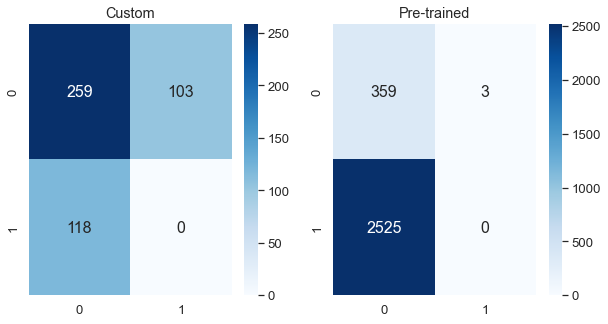

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
labels = ["Custom", "Pre-trained"]
metrics = [metrics_gasp[1], metrics_defaults]
for met, ax,lbl in zip(metrics, axes.flatten(), labels):
    cm_data_1 = []
    cm_data_2 = []

    for m in ('tp', 'fn', 'fp'):
        if m == "tp" or m == "fn":
            cm_data_1.append(met._asdict()[m])
        elif m == "fp":
            cm_data_2.append(met._asdict()[m])
            
    cm_data_2.append(0)  # tn are not known
    cm_data = [cm_data_1, cm_data_2]
    sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d', ax=ax, cbar = True, annot_kws={'fontsize': 16})
    ax.title.set_text(lbl)
    
plt.savefig(r"C:\Users\lazi257c\Desktop\thesis_figures\plantseg_custom_vs_pretrained_cm.png", bbox_inches='tight')

## Boundary based metrics

In [4]:
best_prediction = load_files(os.path.join(module_path, "experiments", "exp14-1_pred_blur8_wtsize", "results-best", "Segmentation", "PostProcessing", "isotropic", "matched"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp14-1_pred_blur8_wtsize\results-best\Segmentation\PostProcessing\isotropic\matched


In [5]:
y_true = load_files(os.path.join(module_path, "data", "matched_test_set", "isotropic"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\matched_test_set\isotropic


In [12]:
y_true = np.array(y_true).astype("int32")

In [13]:
taus = [0.3]
metrics = [matching_dataset(y_true, np.array(best_prediction).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.02s/it]


In [6]:
distance_metrics = get_boundary_based_metrics_per_object(best_prediction, y_true, spacing_mm= (0.001, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [05:49<00:00,  9.97s/it]
metrics.py (319): invalid value encountered in double_scalars
metrics.py (317): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [7]:
pd.set_option('display.max_rows', distance_metrics.shape[0]+1)
res_df_wo_nans= distance_metrics.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final = res_df_wo_nans.reset_index(drop=True)
final

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.584106,0.860516,2.865814,0.458291,0.405712,0.430160,0.830204
1,0.565726,1.329670,7.626358,0.557267,0.477333,0.514425,0.801920
2,0.578271,0.799098,3.334067,0.600633,0.555450,0.577433,0.864616
3,0.540441,0.660757,2.029708,0.630771,0.573884,0.601446,0.860866
4,0.644952,1.085434,4.035019,0.421726,0.348854,0.382232,0.820367
5,0.513902,0.832190,2.941000,0.563768,0.493464,0.526690,0.859478
6,0.556866,1.098510,5.000000,0.590998,0.528498,0.558321,0.865140
7,0.545534,0.921465,3.114000,0.598311,0.525789,0.560142,0.859747
8,0.674078,0.894352,2.476983,0.414542,0.345233,0.377414,0.831860
9,0.716132,0.870962,3.019887,0.514451,0.469645,0.491043,0.840190


In [8]:
final.to_csv(r"metrics/best_pred_distance_metrics_df.csv")

In [9]:
final.describe()

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.576983,1.539591,6.780281,0.653368,0.551705,0.595355,0.845630
std,0.356912,2.672911,10.806333,0.124638,0.111713,0.112438,0.065209
min,0.246509,0.354142,1.052318,0.140750,0.257032,0.183009,0.490278
25%,0.417115,0.722976,2.284644,0.568542,0.480790,0.526578,0.832281
50%,0.513144,0.916115,3.513243,0.655003,0.556191,0.594214,0.864483
75%,0.603825,1.292166,6.861807,0.757457,0.630551,0.685818,0.885273
max,4.295176,21.867480,82.057101,0.907005,0.826721,0.864297,0.928619


In [14]:
metrics_combined = {
    'Mean distance from the GT to predicted surface in microns': final["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": final["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": final["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": final["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": final["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": final["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": final["DSCvol"].mean(),
}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"):
    metrics_combined[m] = metrics[0]._asdict()[m]
metrics_combined

{'Mean distance from the GT to predicted surface in microns': 0.5769826046953441,
 'Mean distance from predicted to the GT surface in microns': 1.5395909269889272,
 'Mean Hausdorff95 distance': 6.780281123348363,
 'Mean surface overlap fraction of GT surfaces with predicted surfaces': 0.6533684998952909,
 'Mean surface overlap fraction of the predicted surfaces with the GT surfaces': 0.5517052697816086,
 'Mean surface DSC': 0.5953552046403098,
 'Mean volume DSC over matched objects': 0.8456299125074488,
 'tp': 352,
 'fn': 10,
 'fp': 30,
 'precision': 0.9214659685863874,
 'recall': 0.9723756906077348,
 'accuracy': 0.8979591836734694,
 'f1': 0.946236559139785,
 'mean_true_score': 0.7171123574451846,
 'mean_matched_score': 0.7374848675998774,
 'panoptic_quality': 0.6978351435353679}

In [16]:
import json

with open("metrics/best_pred_metrics.json", "w") as f:
    json.dump(metrics_combined, f) 